# Dog Breed Identification using VGG16 and Image Augmentation

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2,os
import tensorflow as tf

In [2]:
import kaggle

In [3]:
! mv kaggle.json /root/.kaggle

In [4]:
import kaggle

In [5]:
! kaggle competitions download -c dog-breed-identification

 97% 673M/691M [00:05<00:00, 146MB/s]
100% 691M/691M [00:05<00:00, 128MB/s]


In [6]:
! unzip -q dog-breed-identification.zip

In [7]:
df = pd.read_csv('labels.csv')

In [8]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
dog_category = df.breed.value_counts()
dog_category

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

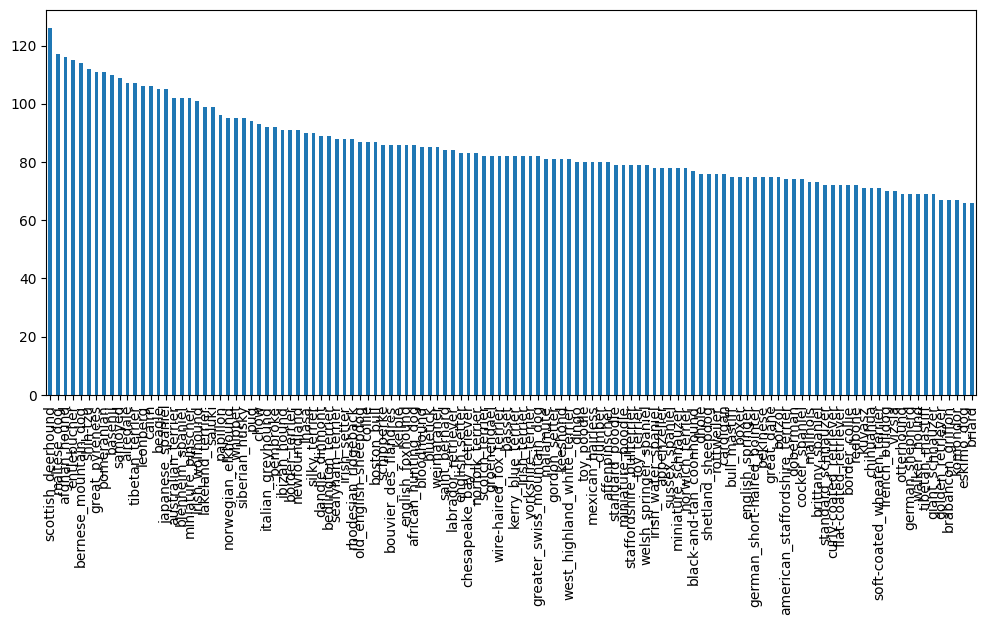

In [10]:
plt.figure(figsize=(12,5))
dog_category.plot.bar()
plt.show()

# Image Generator

In [11]:
# from keras.preprocessing.image import ImageDataGenerator

# idg = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range = 0.25,
#     height_shift_range = 0.25,
#     zoom_range = 0.2
# )

In [12]:
# df.loc[df.id == '000bec180eb18c7604dcecc8fe0dba07']

In [13]:
# image = cv2.imread('train/000bec180eb18c7604dcecc8fe0dba07.jpg')
# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# plt.imshow(image)

In [14]:
# image.shape

In [15]:
# image = np.expand_dims(image,axis=0)

In [16]:
# image.shape

In [17]:
print('Total Number of Unique Dog Breeds: ',len(df.breed.unique()))

Total Number of Unique Dog Breeds:  120


In [18]:
from sklearn.preprocessing import LabelEncoder
num_breeds = 60
im_size = 224
batch_size = 64
encoder = LabelEncoder()

# Preprocessing the data

In [19]:
breed_dict = list(df['breed'].value_counts().keys())
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2+1:2]
df = df.query('breed in @new_list')

In [20]:
df['img_file'] = df['id'].apply(lambda x: x + ".jpg")

<ipython-input-20-ef08f5b3c3a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['img_file'] = df['id'].apply(lambda x: x + ".jpg")


In [21]:
df.head()

,id,breed,img_file
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


# Encoding and scaling the data

In [22]:
train_file = 'train/'
test_file = 'test/'

In [23]:
# load all required libraries for Dog's Breed Identification Project
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model, Model
from keras.optimizers import RMSprop
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

# Encoding Img_id col

In [24]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df), im_size, im_size, 3), dtype='float32')
 
#iterate over img_file column of our dataset
for i, img_id in enumerate(df['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
  train_x[i] = img_array


# Encoding breed names col

In [25]:
train_y = encoder.fit_transform(df['breed'].values)

# Training and testing Splits

In [26]:
X_train,X_test,y_train,y_test = train_test_split(train_x,train_y,test_size=0.20,random_state=42)

# Augmentation

In [27]:
idg = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_idg = idg.flow(X_train,y_train,batch_size=batch_size) # Train idg
test_idg = idg.flow(X_test,y_test,batch_size=batch_size)  # Tset idg


# Build a model 

In [28]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(input_shape=[im_size,im_size,3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [39]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
# resnet = ResNet50V2(input_shape=[im_size,im_size,3],weights='imagenet',include_top=False)

In [30]:
# Freeze all trainble layers

In [40]:
for layer in vgg16.layers:
  layer.trainable = False

In [48]:
# A Functional model
x = tf.keras.layers.Flatten()(vgg16.output)
#FCNN
x = Dense(64,activation='relu')(x) # Hidden layers
output = Dense(num_breeds,activation='softmax') (x) # output layers

model = Model(inputs = vgg16.input , outputs = output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [49]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten True
dense_8 True
dense_9 True


In [50]:
# Compile the model 

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [58]:
epochs = 20
learning_rate = 1e-3
 
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_idg,
                 #steps_per_epoch= X_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_idg)
                 #validation_steps= X_test.shape[0] // batch_size)

Epoch 1/20


ValueError: ignored

In [ ]:

#load the model
model = load_model("model")
 
#get the image of the dog for prediction
pred_img_path = 'rottweiler.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
#display the image of dog
cv2.imshow('demo',cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))) 
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)